<a href="https://colab.research.google.com/github/ashley-ferreira/PHYS449_FinalProject/blob/main/Jordan_Copy_of_PyTorch_CNN_4way_TrainTest_Outline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PHYS 449: Final Project Notebook**
#### Reproducing results from "Morphological classification of galaxies with deep learning: comparing 3-way and 4-way CNNs" by Mitchell K. Cavanagh, Kenji Bekki and Brent A. Groves

*This all just assumed 4-way classification for now

# **Set Current Working Directory**

For example, for Ashley this is:

'/content/drive/MyDrive/Fall 2022/PHYS 449/Final Project'

In [1]:
#CWD = '/content/drive/MyDrive/Fall 2022/PHYS 449/Final Project/' #Ashley's current working directory
CWD = '/content/drive/MyDrive/' #Jordan's current working directory

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import Packages**

Begin by importing all the needed packages

In [3]:
# if you've never used w&b before you need to run these commands, if this gives you issues just comment out w&b stuff for now
#! pip install wandb
#import wandb
#wandb.login()

In [4]:
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Flatten, Conv2D, MaxPool2D
from keras.layers.core import Dropout
import os

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
import re

#DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

# connect to w&b for experiment tracking
#wandb.init(project="CNN-4way-C1-subset", entity="449-final project")

# **Define Network Structure**
We are considering two 2D CNNs, C1 and C2, which are described in the paper and outlined below
- forgot to add batch norm first time

In [6]:
num_classes = 4

In [7]:
# need to double check but this is roughly right
networkc1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=0),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    # max pool here
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    #nn.Linear(135424, 256), 
    # dropout here
    nn.Dropout(0.5),
    nn.ReLU(), # do we need an activation function here?
    nn.Linear(135424,256),
    nn.ReLU(),
    nn.Linear(256, num_classes))

In [8]:
networkc2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=7, stride=1, padding=0),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0),
    nn.ReLU(),
    nn.BatchNorm2d(64),

    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=0),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(kernel_size=2),

    nn.Flatten(),
    nn.Linear(8192, 256),
    nn.Dropout(0.5),

    nn.ReLU(),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Linear(256, num_classes))#Modify last few lines to match Yusuf's Keras model:
    #nn.Linear(256, 4))#,
    #nn.Softmax(dim=4))

https://stackoverflow.com/questions/66626700/difference-between-tensorflows-tf-keras-layers-dense-and-pytorchs-torch-nn-lin#:~:text=Within%20PyTorch%2C%20a%20Linear%20(or,Linear%20layer%20(see%20here).

# **Load Data**

In [9]:
#Import google drive (need to put data folder as shortcut in your local drive My Drive):
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#LOAD THE DATA FROM TXT FILE INTO A BATCH:
def data_batch(datafile_index, num_images=10, data_file=CWD+'/data/data_g_band.txt', plotting=False):
    '''
    Description:
        Access datafile.txt, each row is flattened 110x110 image + 1 label string (E, Sp, S0, Irr+Misc).
        Returns an augmented batch of num_images X 40.
        The labels are converted to 1D vectors (ex: Sp = [0,0,1,0])
        Need to give a datafile_index that tells which rows to pick.
    Inputs:
        datafile_index: index of row in datafile to load. loads rows datafile_index to datafile_index+num_images.
        num_images: number of different images to load per batch, total batch size 
        is 40 X num_images. (default: 10 (for 40X10 = 400 batch size like in paper)
        data_file: datafile full path, need to add shortcut to local Drive. (default: '/content/drive/MyDrive/data/data_g_band.txt')
    Outputs:
        tensor_input_batch_aug: dimensions: (100, 100, num_images X 40). 
        tensor_label_batch_aug: dimensions: (num_images X 40, 4)
    '''

    #Take batch of num_images rows from datafile:
    with open(data_file, 'r') as f:
        rows = f.readlines()[datafile_index:(datafile_index+num_images)]

    #for batch size of 400 (augmented), need 10 images
    data_batch = np.zeros((num_images,12101), dtype=np.dtype('U10'))
    count = 0
    for row in rows:
        data_batch[count,:] = row.split()
        count += 1

    #separate label and input:
    input_batch_flat = np.array(data_batch[:,:12100], dtype=float)#, dtype=int)
    label_batch = np.array(data_batch[:,-1])

    #convert input batch back to a 2D array:
    input_batch = np.zeros((110,110,np.shape(input_batch_flat)[0]))#, dtype=int)
    for ii in range(np.shape(input_batch_flat)[0]):
        input_batch[:,:,ii] = np.reshape(input_batch_flat[ii,:], (110,110))


    #convert label batch into into 1D vector: 
    #E=0, S0=1, Sp=2, Irr+Misc=3
    #ex: label = [0,0,1,0] ==> Sp galagy
    arr_label_batch = np.zeros((np.shape(label_batch)[0],4), dtype=int)
    arr_label_batch[:,0] = np.array([label_batch == 'E'], dtype=int)
    arr_label_batch[:,1] = np.array([label_batch == 'Sp'], dtype=int)
    arr_label_batch[:,2] = np.array([label_batch == 'S0'], dtype=int)
    arr_label_batch[:,3] = np.array([label_batch == 'Irr+Misc'], dtype=int)

    if plotting == True:
      #test with image plotted
      plt.imshow(input_batch[:,:,0])
      plt.show()

    #NOW AUGMENT THE BATCH (40X more):
    input_batch_aug = np.empty((100,100,np.shape(input_batch)[2]*40), dtype=int)
    arr_label_batch_aug = np.empty((np.shape(arr_label_batch)[0]*40, 4), dtype=int)

    count = 0
    for ll in range(np.shape(input_batch)[2]):
        #Crop 5X more image (100X100 pixels)
        C1 = input_batch[:100,:100,ll]
        C2 = input_batch[10:,:100,ll]
        C3 = input_batch[:100,10:,ll]
        C4 = input_batch[10:,10:,ll]
        C5 = input_batch[5:105,5:105,ll]

        C = [C1, C2, C3, C4, C5]

        for kk in range(5):
            #Rotate 4X more image (by 90 deg)
            for jj in range(4):
                C_R = np.rot90(C[kk], k=jj)
                input_batch_aug[:,:,count] = C_R
                arr_label_batch_aug[count,:] = arr_label_batch[ll,:]
                count += 1
                
                input_batch_aug[:,:,count] = np.swapaxes(C_R,0,1)
                arr_label_batch_aug[count,:] = arr_label_batch[ll,:]
                count += 1


    #PUT THE DATA AS A PYTORCH TENSOR:
    tensor_input_batch_aug = torch.Tensor(input_batch_aug)
    tensor_label_batch_aug = torch.Tensor(arr_label_batch_aug)
    
    return tensor_input_batch_aug, tensor_label_batch_aug


In [11]:
# ashley's troubleshooting
'''
rand_index = np.random.permutation(280)

print(np.shape(rand_index)[0])

#Use this loop for training over entire dataset at each epochs
for ii in range(np.shape(rand_index)[0]):
  image_batch, label_batch = data_batch(datafile_index=50*rand_index[ii], num_images=50)
  #print(np.shape(image_batch), np.shape(label_batch))
  #print(ii)
'''

'\nrand_index = np.random.permutation(280)\n\nprint(np.shape(rand_index)[0])\n\n#Use this loop for training over entire dataset at each epochs\nfor ii in range(np.shape(rand_index)[0]):\n  image_batch, label_batch = data_batch(datafile_index=50*rand_index[ii], num_images=50)\n  #print(np.shape(image_batch), np.shape(label_batch))\n  #print(ii)\n'

# **Sample Data**
Here we check that the data files are how we expect them to be

In [12]:
# can just call data load for some if we made plotting an optional arg
#rand_index = np.random.permutation(10)
#print(np.shape(rand_index)[0])
#for ii in range(np.shape(rand_index)[0]):
#  image_batch, label_batch = data_batch(datafile_index=50*rand_index[ii], num_images=50, plotting = True)

# **Split Data**
Here we split data into trainng, testing datasets (validation split will be done by keras during training)

# **Training**
Ideally we use seperate notebooks to train each one

C2 uses Adam, wheras C1 uses Adadelta: 

  https://www.aanda.org/articles/aa/full_html/2020/09/aa37963-20/aa37963-20.html


In [13]:
network_to_train = 'C2'

# define hyperparameters of training
if network_to_train == 'C1':
  n_epochs = 12
  # can't find learning rate mentioned so I'm leaving it as default for now
  cn_model = networkc1
  #optimizer = torch.optim.Adadelta(cn_model.parameters()))
  # trying adam for a sec
  optimizer = torch.optim.Adam(cn_model.parameters(), lr=2e-4)

elif network_to_train == 'C2':
  n_epochs = 20
  cn_model = networkc2
  lr = 2*pow(10,-4)
  optimizer = torch.optim.Adam(cn_model.parameters(), lr=lr)

In [14]:
# define things that are the same for both notebooks
class_weight = torch.Tensor(np.array([2723, 7708, 3215, 388], dtype=np.float32)/14034).detach().to('cuda')
loss_fn = torch.nn.CrossEntropyLoss(weight = class_weight)
#loss_fn = torch.nn.CrossEntropyLoss()

In [15]:
# add some code here to reset weights if we run this a lot

In [16]:
# Initialize network & move to GPU
#cn_model.to(DEVICE)  # comment out if this gives you issues
cn_model.to('cuda')

Sequential(
  (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (8): ReLU()
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (12): ReLU()
  (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=8192, out_features=256, bias=True)
 

In [17]:
#Train and test set
dataset_size = 20#93#1403 # WHENEVER YOU SEE THIS LESS THAN 1403 IT'S ARTIFIFICALLY SMALL JUST TO TROUBLESHOOT CODE AND SHOULD NOT BE USED TO TRAIN
train_split = 0.7
test_split = 1 - train_split
split_cutoff = int(dataset_size*train_split)

rand_index = np.random.permutation(dataset_size)
rand_train = rand_index[:split_cutoff] # get these split like paper proportions
rand_test = rand_index[split_cutoff:dataset_size] # valudation will be taken from test set

In [18]:
# For monitoring acc and losses
avg_epoch_acc_train = []
avg_epoch_acc_val = []
avg_epoch_losses_train = []
avg_epoch_losses_val = []

num_images = 150
batch_size = num_images*40 

print('Model initialized and prepped, begin training...')

for epoch in range(n_epochs):  
    cn_model.train()
    print('epoch:', epoch+1)

    #VALIDATION FOR before any training! (just once)
    if epoch == 0:
        ds_valid_size = 0
        cn_model.eval()
        epoch_loss = 0
        test_total_accuracy = 0
        with torch.no_grad():
          for ii in range(np.shape(rand_test)[0]):
            im_valid, y_valid = data_batch(datafile_index=num_images*rand_test[ii], num_images=num_images)
            im_valid = im_valid.reshape(100, 100, 1, im_valid.shape[2])
            im_valid = im_valid.T

            #print(np.shape(im_valid))
            #plt.imshow(im_valid[0,0,:,:])
            #plt.show()

            im_valid = im_valid.detach().to('cuda')
            y_valid = y_valid.detach().to('cuda')

            y_pred_valid = cn_model(im_valid)
            y_pred_valid_cat = nn.functional.softmax(y_pred_valid, dim=1)

            #updated accuracy calculation:
            test_predictions = torch.argmax(y_pred_valid_cat, dim=1)
            test_label_predictions = torch.argmax(y_valid, dim=1)
            test_batch_size = np.shape(test_predictions)[0]
            test_batch_accuracy = torch.sum(test_predictions == test_label_predictions).item()/test_batch_size
            print(f'\t\t test batch accuracy = {np.round(100*test_batch_accuracy,2)} %, batch # {ds_valid_size}')
            test_total_accuracy += test_batch_accuracy

            loss = loss_fn(y_pred_valid, y_valid)
            epoch_loss += loss.item()
            ds_valid_size += 1

            #delete image and label every loop train:
            del im_valid
            del y_valid
            torch.cuda.empty_cache()
          
          #calculate total loss validation
          v_loss = epoch_loss / ds_valid_size
          avg_epoch_losses_val.append(v_loss)
          print('validation loss:', np.round(v_loss,2))

          #calculate total accuracy validation
          test_total_accuracy = 100 * test_total_accuracy / np.shape(rand_test)[0]
          print('Validation accuracy:', np.round(test_total_accuracy,2), '%')
          avg_epoch_acc_val.append(test_total_accuracy)



    # quick fix to get training dataset size
    ds_size = 0
    
    train_total_accuracy = 0
    epoch_loss = 0
    for ii in range(np.shape(rand_train)[0]): 
      #print('batch', ii+1, '/', batch_size)
      im, y = data_batch(datafile_index=num_images*rand_train[ii], num_images=num_images)

      # reshaping im to what we want (can do this as data output too)
      im = im.reshape(100, 100, 1, im.shape[2])
      im = im.T

      im = im.detach().to('cuda')
      y = y.detach().to('cuda')

      y_pred = cn_model(im)
      y_pred_cat = nn.functional.softmax(y_pred, dim=1)
      #print(np.shape(y_pred))
      #print(np.shape(y_pred_cat))
      

      #updated accuracy calculation:
      #train_predictions = torch.argmax(y_pred, dim=1)
      train_predictions = torch.argmax(y_pred_cat, dim=1)
      train_label_predictions = torch.argmax(y, dim=1)
      train_batch_size = np.shape(train_predictions)[0]
      train_batch_accuracy = torch.sum(train_predictions == train_label_predictions).item()/train_batch_size
      print(f'\t\t train batch accuracy = {np.round(100*train_batch_accuracy,2)} %, batch # {ds_size}')
      train_total_accuracy += train_batch_accuracy

      # im doing the backprop after each batch
      # (we may just want to do after each epoch)
      #loss = loss_fn(y_pred_cat, y)
      loss = loss_fn(y_pred, y) #commented out because this does not have the softmax applied to it (does it?)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
      ds_size += 1

      #delete image and label every loop train:
      #im = im.detach() #try to make sure not saved image and label
      #y = y.detach()

      del im
      del y
      torch.cuda.empty_cache()

    t_loss = epoch_loss / ds_size
    print('training loss:', np.round(t_loss,2))
    avg_epoch_losses_train.append(t_loss)

    train_total_accuracy = 100 * train_total_accuracy / np.shape(rand_train)[0]
    print('training accuracy:', np.round(train_total_accuracy,2), '%')
    avg_epoch_acc_train.append(train_total_accuracy)


    #NEW VALIDATION:----------------------------------

    ds_valid_size = 0
    cn_model.eval() #what does that do?
    epoch_loss = 0
    test_total_accuracy = 0
    with torch.no_grad():
      for ii in range(np.shape(rand_test)[0]):
        im_valid, y_valid = data_batch(datafile_index=num_images*rand_test[ii], num_images=num_images)
        im_valid = im_valid.reshape(100, 100, 1, im_valid.shape[2])
        im_valid = im_valid.T

        im_valid = im_valid.detach().to('cuda')
        y_valid = y_valid.detach().to('cuda')

        y_pred_valid = cn_model(im_valid)
        y_pred_valid_cat = nn.functional.softmax(y_pred_valid, dim=1)

        #updated accuracy calculation:
        test_predictions = torch.argmax(y_pred_valid_cat, dim=1)
        test_label_predictions = torch.argmax(y_valid, dim=1)
        test_batch_size = np.shape(test_predictions)[0]
        test_batch_accuracy = torch.sum(test_predictions == test_label_predictions).item()/test_batch_size
        print(f'\t\t test batch accuracy = {np.round(100*test_batch_accuracy,2)} %, batch # {ds_valid_size}')
        test_total_accuracy += test_batch_accuracy

        loss = loss_fn(y_pred_valid, y_valid)
        epoch_loss += loss.item()
        ds_valid_size += 1

        #delete image and label every loop train:
        del im_valid
        del y_valid
        torch.cuda.empty_cache()
      
      #calculate total loss validation
      v_loss = epoch_loss / ds_valid_size
      avg_epoch_losses_val.append(v_loss)
      print('validation loss:', np.round(v_loss,2))

      #calculate total accuracy validation
      test_total_accuracy = 100 * test_total_accuracy / np.shape(rand_test)[0]
      print('Validation accuracy:', np.round(test_total_accuracy,2), '%')
      avg_epoch_acc_val.append(test_total_accuracy)


print("DONE TRAINING")

Model initialized and prepped, begin training...
epoch: 1


<ipython-input-18-981f44592df6>:26: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)
  im_valid = im_valid.T


		 test batch accuracy = 22.55 %, batch # 0
		 test batch accuracy = 26.93 %, batch # 1
		 test batch accuracy = 21.1 %, batch # 2
		 test batch accuracy = 23.52 %, batch # 3
		 test batch accuracy = 20.85 %, batch # 4
		 test batch accuracy = 23.28 %, batch # 5
validation loss: 0.57
Validation accuracy: 23.04 %
		 train batch accuracy = 23.03 %, batch # 0
		 train batch accuracy = 54.0 %, batch # 1
		 train batch accuracy = 66.0 %, batch # 2
		 train batch accuracy = 60.0 %, batch # 3
		 train batch accuracy = 58.0 %, batch # 4
		 train batch accuracy = 54.0 %, batch # 5
		 train batch accuracy = 55.33 %, batch # 6
		 train batch accuracy = 50.67 %, batch # 7
		 train batch accuracy = 42.0 %, batch # 8
		 train batch accuracy = 56.0 %, batch # 9
		 train batch accuracy = 52.0 %, batch # 10
		 train batch accuracy = 46.67 %, batch # 11
		 train batch accuracy = 50.0 %, batch # 12
		 train batch accuracy = 56.0 %, batch # 13
training loss: 0.35
training accuracy: 51.69 %
		 test batch a

Ashley's troubleshooting notes:
- I actually run into the issue again when I try num_images = 50, but num_images = 10 seems to be totally fine
- I thought the issue was due to us using empty in the data loading function and it using old memory so I did make some changes in that function like replacing that with zeros
- C1 might not be working due to different stride and no set learning rate
- The paper also seems to have weird learning results...

[51.69285714 52.525      53.79047619 49.22738095 48.27619048 54.13690476
 49.25       48.30238095 54.06547619 53.83571429 52.72738095 49.67380952
 51.96071429 54.0797619  54.03928571 53.8        52.81666667 52.60595238
 53.50952381 54.00595238] [23.03888889 54.33333333 54.33333333 54.33333333 23.39444444 53.58333333
 54.32222222 50.07777778 54.31111111 54.33333333 54.33333333 52.03333333
 52.54166667 54.33333333 54.33333333 54.33333333 54.33333333 53.50277778
 54.31388889 54.33055556 54.33333333] [0.35343128 0.32284785 0.38294904 0.35708692 0.39068128 0.42855825
 0.34728627 0.36699776 0.34595469 0.38994063 0.32904896 0.36266924
 0.35263958 0.37094484 0.36343912 0.31574142 0.31675539 0.3222651
 0.31770521 0.32571628] [0.56534955 0.38969448 0.34153931 0.62871281 0.54321982 0.45380759
 0.38878122 0.37377827 0.36970651 0.3626753  0.33408519 0.33684464
 0.36347478 0.31375856 0.2902077  0.28785317 0.2915049  0.31745275
 0.32724137 0.29646777 0.28556524]


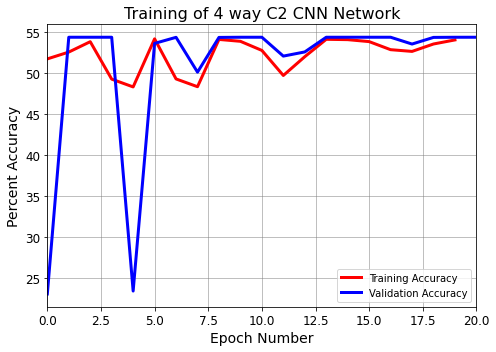

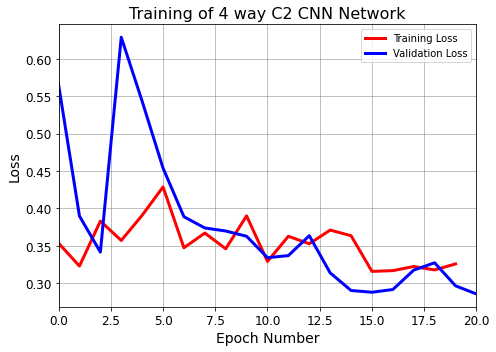

In [19]:
train_acc = np.array(avg_epoch_acc_train)
valid_acc = np.array(avg_epoch_acc_val)
train_loss = np.array(avg_epoch_losses_train)
valid_loss = np.array(avg_epoch_losses_val)

print(train_acc, valid_acc, train_loss, valid_loss)

#Plot accuracy results:
plt.figure(figsize=(7,5)) #set plot size

plt.plot(range(np.shape(train_acc)[0]), train_acc, label='Training Accuracy', 
             linestyle='-', color='red', linewidth=3)
plt.plot(range(np.shape(valid_acc)[0]), valid_acc, label='Validation Accuracy', 
             linestyle='-', color='blue', linewidth=3)

plt.yticks(fontsize=12, rotation=0) #adjust axis tick numbers font size
plt.xticks(fontsize=12, rotation=0) #adjust axis tick numbers font size
plt.xlabel('Epoch Number', fontsize=14) #set axis label
plt.ylabel('Percent Accuracy', fontsize=14) #set axis label
plt.title('Training of 4 way C2 CNN Network', fontsize=16) #set title
plt.legend(fontsize=10)
plt.xlim(0, np.shape(train_acc)[0]) #set axis limits
plt.grid(True, which='minor', color='gray', linestyle='--', linewidth=1, alpha=0.2) #set gridlines
plt.grid(True, which='major', color='gray', linestyle='-', linewidth=1, alpha=0.5) #set gridlines
plt.tight_layout()
plt.savefig(CWD+'data/Jordan_C2_4way_Accuracy_plot_v7.png',dpi=300)
#plt.close() #Stops the figure from being shown
plt.show() #display the figure



#Plot loss results:
plt.figure(figsize=(7,5)) #set plot size

plt.plot(range(np.shape(train_loss)[0]), train_loss, label='Training Loss', 
             linestyle='-', color='red', linewidth=3)
plt.plot(range(np.shape(valid_loss)[0]), valid_loss, label='Validation Loss', 
             linestyle='-', color='blue', linewidth=3)

plt.yticks(fontsize=12, rotation=0) #adjust axis tick numbers font size
plt.xticks(fontsize=12, rotation=0) #adjust axis tick numbers font size
plt.xlabel('Epoch Number', fontsize=14) #set axis label
plt.ylabel('Loss', fontsize=14) #set axis label
plt.title('Training of 4 way C2 CNN Network', fontsize=16) #set title
plt.legend(fontsize=10)
plt.xlim(0, np.shape(train_acc)[0]) #set axis limits
plt.grid(True, which='minor', color='gray', linestyle='--', linewidth=1, alpha=0.2) #set gridlines
plt.grid(True, which='major', color='gray', linestyle='-', linewidth=1, alpha=0.5) #set gridlines
plt.tight_layout()
#plt.yscale('log')
plt.savefig(CWD+'data/Jordan_C2_4way_Loss_plot_v7.png',dpi=300)
#plt.close() #Stops the figure from being shown
plt.show() #display the figure

In [20]:
# save model itself 
#torch.save(cn_model.state_dict(), CWD+'data/test_model1_jordan')#, CWD + 'Notebooks/models/')

In [21]:
'''
# plot accuracy/loss versus epoch
fig1 = plt.figure(figsize=(10,3))


ax1 = plt.subplot(121)
ax1.plot(avg_epoch_acc_train, '--', color='darkslategray', linewidth=2, label='training')
ax1.plot(avg_epoch_acc_val, linewidth=2, label='valiation') 
ax1.legend()
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

ax2 = plt.subplot(122)
ax2.plot(avg_epoch_losses_train, '--', color='crimson', linewidth=2, label='training')
ax2.plot(avg_epoch_losses_val, linewidth=2, label='validation')
ax2.legend()
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')

fig1.savefig(CWD + 'Notebooks/plots/'+'CNN_training_history.png')

plt.show()
'''

"\n# plot accuracy/loss versus epoch\nfig1 = plt.figure(figsize=(10,3))\n\n\nax1 = plt.subplot(121)\nax1.plot(avg_epoch_acc_train, '--', color='darkslategray', linewidth=2, label='training')\nax1.plot(avg_epoch_acc_val, linewidth=2, label='valiation') \nax1.legend()\nax1.set_title('Model Accuracy')\nax1.set_ylabel('Accuracy')\nax1.set_xlabel('Epoch')\n\nax2 = plt.subplot(122)\nax2.plot(avg_epoch_losses_train, '--', color='crimson', linewidth=2, label='training')\nax2.plot(avg_epoch_losses_val, linewidth=2, label='validation')\nax2.legend()\nax2.set_title('Model Loss')\nax2.set_ylabel('Loss')\nax2.set_xlabel('Epoch')\n\nfig1.savefig(CWD + 'Notebooks/plots/'+'CNN_training_history.png')\n\nplt.show()\n"

# **Testing - Don't run this yet, it's not done **
Here we apply the model to the test set and create a confusion matrix to gauge performance

In [22]:
'''
#@title
### ADAPT THIS TO GET TEST SET STATS (way to make it not do data augmentation and just stick with original images?)
for ii in range(np.shape(rand_test)[0]):
  if ii == 0:
    pass
  else:
    image_batch, label_batch = data_batch(datafile_index=50*rand_test[ii], num_images=50)
'''

'\n#@title\n### ADAPT THIS TO GET TEST SET STATS (way to make it not do data augmentation and just stick with original images?)\nfor ii in range(np.shape(rand_test)[0]):\n  if ii == 0:\n    pass\n  else:\n    image_batch, label_batch = data_batch(datafile_index=50*rand_test[ii], num_images=50)\n'

In [23]:
'''
#@title
# make predictions on test set and compare to real labels
preds_test = cn_model.predict(X_test, verbose=1)
results = cn_model.evaluate(X_test, y_test) 
print("test loss, valid acc:", results)
'''

'\n#@title\n# make predictions on test set and compare to real labels\npreds_test = cn_model.predict(X_test, verbose=1)\nresults = cn_model.evaluate(X_test, y_test) \nprint("test loss, valid acc:", results)\n'

In [24]:
'''
#@title
# plot confusion matrix
fig2 = plt.figure()
cm = confusion_matrix(y_valid, preds_valid)
plt.matshow(cm)

for (i, j), z in np.ndenumerate(cm):
    pyl.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.title('Confusion matrix (validation data)')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
plt.savefig(model_dir_name +'plots/'+'CNN_confusion_matrix.png')
'''

"\n#@title\n# plot confusion matrix\nfig2 = plt.figure()\ncm = confusion_matrix(y_valid, preds_valid)\nplt.matshow(cm)\n\nfor (i, j), z in np.ndenumerate(cm):\n    pyl.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')\nplt.title('Confusion matrix (validation data)')\nplt.colorbar()\nplt.xlabel('Predicted labels')\nplt.ylabel('True labels')\nplt.show()\nplt.savefig(model_dir_name +'plots/'+'CNN_confusion_matrix.png')\n"